# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 


#### Goal is determine what makes the used car more or less expensive ?


What factors make the car more or less expensive ?

What features can drive the car price ?

Would correlation matrix help determine what features are important?

What Alogirthm can be used for  training ?



### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [106]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# Suppress warnings
warnings.filterwarnings('ignore')

In [51]:
car = pd.read_csv('data/vehicles.csv')

In [52]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [53]:
car.shape

(426880, 18)

In [54]:
car.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [55]:
car.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [56]:
# getting the percent of null/missing  values in the dataset  
print(car.isnull().sum() / 426880 * 100)

id               0.000000
region           0.000000
price            0.000000
year             0.282281
manufacturer     4.133714
model            1.236179
condition       40.785232
cylinders       41.622470
fuel             0.705819
odometer         1.030735
title_status     1.930753
transmission     0.598763
VIN             37.725356
drive           30.586347
size            71.767476
type            21.752717
paint_color     30.501078
state            0.000000
dtype: float64


In [57]:
car.head(100)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7309798041,auburn,2100,2006.0,subaru,impreza,fair,4 cylinders,gas,97000.0,clean,automatic,NaN,NaN,NaN,hatchback,NaN,al
96,7309361405,auburn,80,2004.0,honda,NaN,excellent,6 cylinders,gas,94020.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,al
97,7309271279,auburn,15990,2016.0,NaN,Scion iM Hatchback 4D,good,NaN,gas,29652.0,clean,other,JTNKARJEXGJ517925,fwd,NaN,hatchback,blue,al
98,7309271051,auburn,20590,2013.0,acura,mdx sport utility 4d,good,6 cylinders,gas,77087.0,clean,other,2HNYD2H30DH510846,NaN,NaN,other,silver,al


#### Understanding the data as well as probelm Data has following columns 


What is missing? 
Checking the null values in the columns 

Any features or columns that have missing data of 30 % or more  will be removed from the car dataframe.

Size : 71%
VIN : 37 %
drive : 30 %
Paint : 30 %
Condition : 40%
Cylinders:  41%

### Some pre assumptions about features in the dataset based on general observation 

'region'  :
It can make a difference in determining the price, since more areas that mositure, rain,  heavy, snow flooding can reduce the price of car, damages can be rust or engine related.   

'price' : Price what we need to determine

'year' : Year can determine the how old the car 

'manufacturer':
Some manafatures have name recogonition so people tend to pay higher price for them

'model' :
Model plays important role when looking at the cars features.

'fuel', 

'odometer', : 
Is one of the better indicator of how much the car is used so it will determine the car

'title_status': 
Is relevant for the dealer so they can resell the car

'transmission':
Is important People in general tend to use Automatic 
[nan, 'other', 'automatic', 'manual']


'VIN': 
Not important for modeling

'drive':
Can have impact to price of the car 
[nan, 'rwd', '4wd', 'fwd']


'type':
Type usually can impact the price since there have been trends that made more car more desirable. Since 1990 SUV have been selling more in general and trend has continued, and manafactures have introduced more SUV models to accomodate that.  
array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
       'wagon']

'state':
State like region will be relevent since it plays into where it was driven (moist area with lots of rain, sunny with high degree temperature or cold) this could effect the paint mostly and inside interior. 


how old the car is ?

whats the model of the car ?

what makes the make of the car?



Linear Regression to detmine the future care value.

Linear Regession 
Lasso Regression 
Polynomial Features 

In [58]:
car.transmission.unique()

array([nan, 'other', 'automatic', 'manual'], dtype=object)

In [59]:
car.drive.unique()

array([nan, 'rwd', '4wd', 'fwd'], dtype=object)

In [60]:
car.type.unique()

array([nan, 'pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'bus', 'van', 'convertible',
       'wagon'], dtype=object)

In [61]:
car.region.unique()

array(['prescott', 'fayetteville', 'florida keys',
       'worcester / central MA', 'greensboro', 'hudson valley',
       'medford-ashland', 'erie', 'el paso', 'bellingham',
       'skagit / island / SJI', 'la crosse', 'auburn', 'birmingham',
       'dothan', 'florence / muscle shoals', 'gadsden-anniston',
       'huntsville / decatur', 'mobile', 'montgomery', 'tuscaloosa',
       'anchorage / mat-su', 'fairbanks', 'kenai peninsula',
       'southeast alaska', 'flagstaff / sedona', 'mohave county',
       'phoenix', 'show low', 'sierra vista', 'tucson', 'yuma',
       'fort smith', 'jonesboro', 'little rock', 'texarkana',
       'bakersfield', 'chico', 'fresno / madera', 'gold country',
       'hanford-corcoran', 'humboldt county', 'imperial county',
       'inland empire', 'los angeles', 'mendocino county', 'merced',
       'modesto', 'monterey bay', 'orange county', 'palm springs',
       'redding', 'reno / tahoe', 'sacramento', 'san diego',
       'san luis obispo', 'santa barbara',

In [62]:
car.state.unique()

array(['az', 'ar', 'fl', 'ma', 'nc', 'ny', 'or', 'pa', 'tx', 'wa', 'wi',
       'al', 'ak', 'ca', 'co', 'ct', 'dc', 'de', 'ga', 'hi', 'id', 'il',
       'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'mi', 'mn', 'ms', 'mo',
       'mt', 'ne', 'nv', 'nj', 'nm', 'nh', 'nd', 'oh', 'ok', 'ri', 'sc',
       'sd', 'tn', 'ut', 'vt', 'va', 'wv', 'wy'], dtype=object)

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [86]:
car_prepdf = car.drop(['id','size', 'VIN', 'drive', 'condition','cylinders' , 'paint_color'] , axis=1, inplace=False)


In [87]:
print (car_prepdf.columns)

Index(['region', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer',
       'title_status', 'transmission', 'type', 'state'],
      dtype='object')


In [88]:
#drop NA values 
car_prepdf.dropna(inplace=True)

In [89]:
#changing the year to int value from float

car_prepdf['year'] = car_prepdf['year'].astype(int)
car_prepdf['odometer'] = car_prepdf['odometer'].astype(int)


In [90]:
car_prepdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306976 entries, 27 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        306976 non-null  object
 1   price         306976 non-null  int64 
 2   year          306976 non-null  int64 
 3   manufacturer  306976 non-null  object
 4   model         306976 non-null  object
 5   fuel          306976 non-null  object
 6   odometer      306976 non-null  int64 
 7   title_status  306976 non-null  object
 8   transmission  306976 non-null  object
 9   type          306976 non-null  object
 10  state         306976 non-null  object
dtypes: int64(3), object(8)
memory usage: 28.1+ MB


In [91]:
car_prepdf.query('price== 0').count()

region          23209
price           23209
year            23209
manufacturer    23209
model           23209
fuel            23209
odometer        23209
title_status    23209
transmission    23209
type            23209
state           23209
dtype: int64

In [92]:
#drop rows price is 0
car_prepdf = car_prepdf.query('price > 0') 

In [93]:
car_prepdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283767 entries, 27 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        283767 non-null  object
 1   price         283767 non-null  int64 
 2   year          283767 non-null  int64 
 3   manufacturer  283767 non-null  object
 4   model         283767 non-null  object
 5   fuel          283767 non-null  object
 6   odometer      283767 non-null  int64 
 7   title_status  283767 non-null  object
 8   transmission  283767 non-null  object
 9   type          283767 non-null  object
 10  state         283767 non-null  object
dtypes: int64(3), object(8)
memory usage: 26.0+ MB


In [94]:
# droping duplicates
car_prepdf.drop_duplicates(inplace=True)

In [95]:
# drop nan rows

car_prepdf.dropna(inplace=True)

In [96]:
car_prepdf.shape

(249893, 11)

In [97]:
#checking for nan 
car_prepdf.type.unique()

array(['pickup', 'truck', 'other', 'coupe', 'SUV', 'hatchback',
       'mini-van', 'sedan', 'offroad', 'convertible', 'wagon', 'van',
       'bus'], dtype=object)

In [99]:
car_df = car_prepdf
# creating numeric data frame
df_c = car_df.copy()
for column in car_df.select_dtypes(include='object').columns.tolist():
    df_c[column] = pd.factorize(df_c[column])[0]

<Axes: >

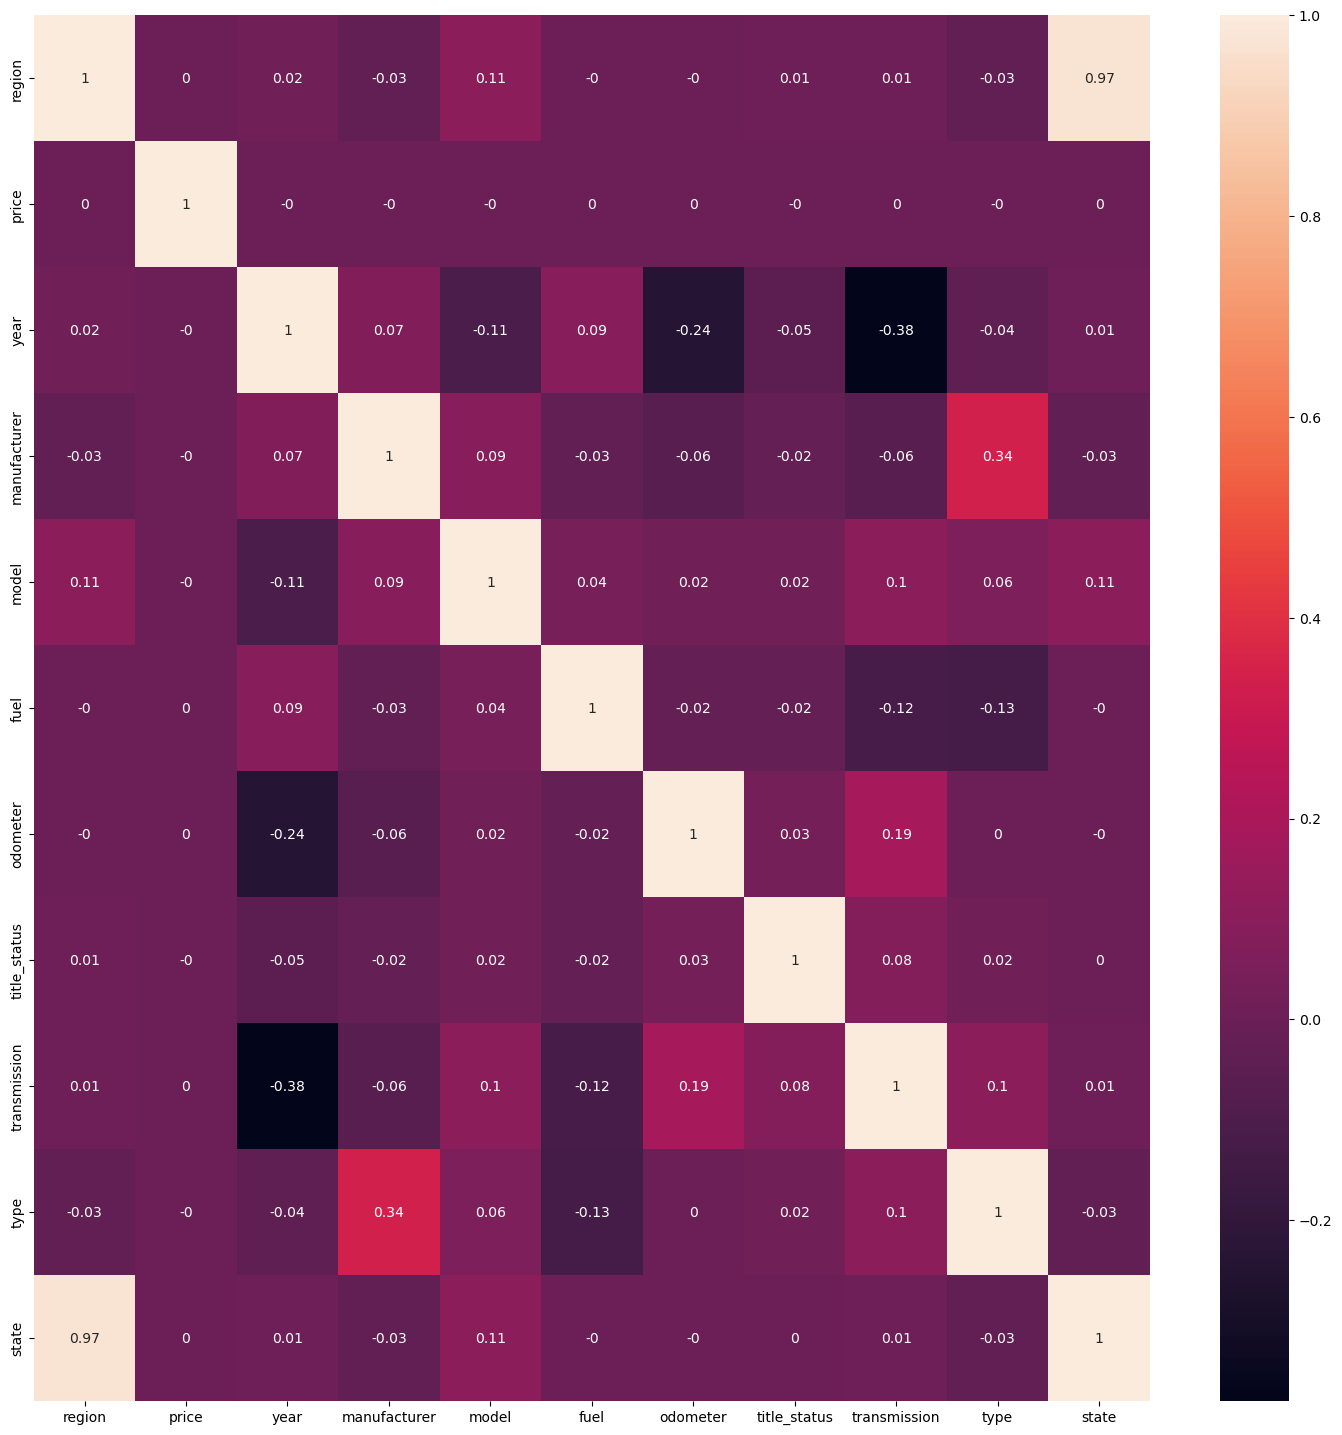

In [102]:
# correlation Matrix

corr=df_c.corr()
plt.figure(figsize=(18,18))
sns.heatmap(corr.round(2),annot=True)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [125]:
#split the data in train and test
target = 'price'
X = df_c.drop(target, axis=1)
y = df_c[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=32)

In [126]:
#Linear Regression pipeline 
linearpipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', LinearRegression()) 
])

linearpipeline.fit(X_train, y_train)

y_train_predict = linearpipeline.predict(X_train)
y_test_predict = linearpipeline.predict(X_test)


# Model evaluation
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_test_predict))
print('Coefficient of determination (R^2): %.10f' % r2_score(y_test, y_test_predict))

print("Mean squared error: %.2f" % mean_squared_error(y_train, y_train_predict))
print('Coefficient of determination (R^2): %.10f' % r2_score(y_train, y_train_predict))


Mean squared error: 202939281599853.78
Coefficient of determination (R^2): -0.0000012351
Mean squared error: 11645379808419.72
Coefficient of determination (R^2): 0.0001070683


In [116]:
df_c.columns

Index(['region', 'price', 'year', 'manufacturer', 'model', 'fuel', 'odometer',
       'title_status', 'transmission', 'type', 'state'],
      dtype='object')

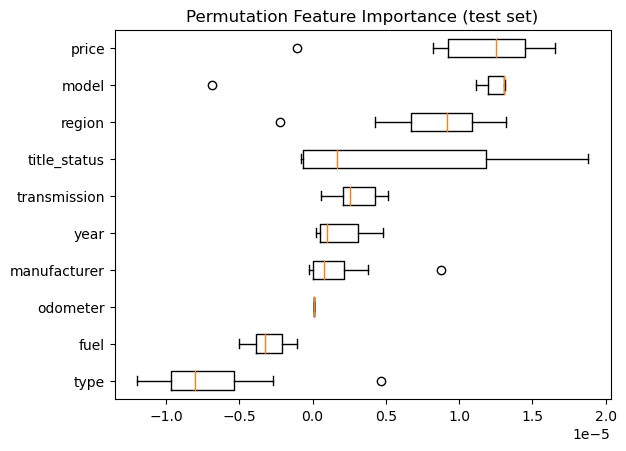

In [127]:

# Perform permutation feature importance
result = permutation_importance(linearpipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Organize the results
sorted_idx = result.importances_mean.argsort()

# Plot the results
fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=np.array(df_c.columns)[sorted_idx])
ax.set_title("Permutation Feature Importance (test set)")
plt.show()

### Box Plot shows the importance of the features
Findings suggest that the price is important followed by model, region, title, transmission, year so on using the Linear Regression


In [128]:
#Ridge Regression pipeline 
ridgepipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('regressor', Ridge()) 
])

ridgepipeline.fit(X_train, y_train)

y_train_predict_r = ridgepipeline.predict(X_train)
y_test_predict_r = ridgepipeline.predict(X_test)


# Model evaluation
print("Mean squared error Ridge : %.2f" % mean_squared_error(y_test, y_test_predict_r))
print('Coefficient of determination (R^2): %.10f' % r2_score(y_test, y_test_predict_r))

print("Mean squared error Ridge : %.2f" % mean_squared_error(y_train, y_train_predict_r))
print('Coefficient of determination (R^2): %.10f' % r2_score(y_train, y_train_predict_r))

Mean squared error Ridge : 202939281603527.84
Coefficient of determination (R^2): -0.0000012351
Mean squared error Ridge : 11645379808420.02
Coefficient of determination (R^2): 0.0001070683


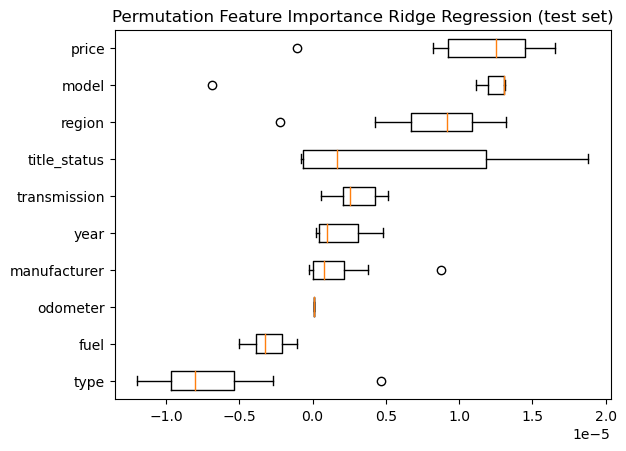

In [148]:
# Perform permutation ridge feature importance
resultsr = permutation_importance(ridgepipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Organize the results
sorted_idx = resultsr.importances_mean.argsort()

# Plot the results
fig, ax = plt.subplots()
ax.boxplot(resultsr.importances[sorted_idx].T,
           vert=False, labels=np.array(df_c.columns)[sorted_idx])
ax.set_title("Permutation Feature Importance Ridge Regression (test set)")
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
Linear Regression vs Ridge Regression the mean squared error is similar.

Linear
Mean squared error: 202939281599853.78
Coefficient of determination (R^2): -0.0000012351
Mean squared error: 11645379808419.72
Coefficient of determination (R^2): 0.0001070683

Ridge:
Mean squared error Ridge : 202939281603527.84
Coefficient of determination (R^2): -0.0000012351
Mean squared error Ridge : 11645379808420.02
Coefficient of determination (R^2): 0.0001070683
    
Ridge regression handles large data better and tends to give well distributed weights. 
Ridge would work better with larger dataset.
    
    

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Text(784.1881313131312, 0.5, 'Price')

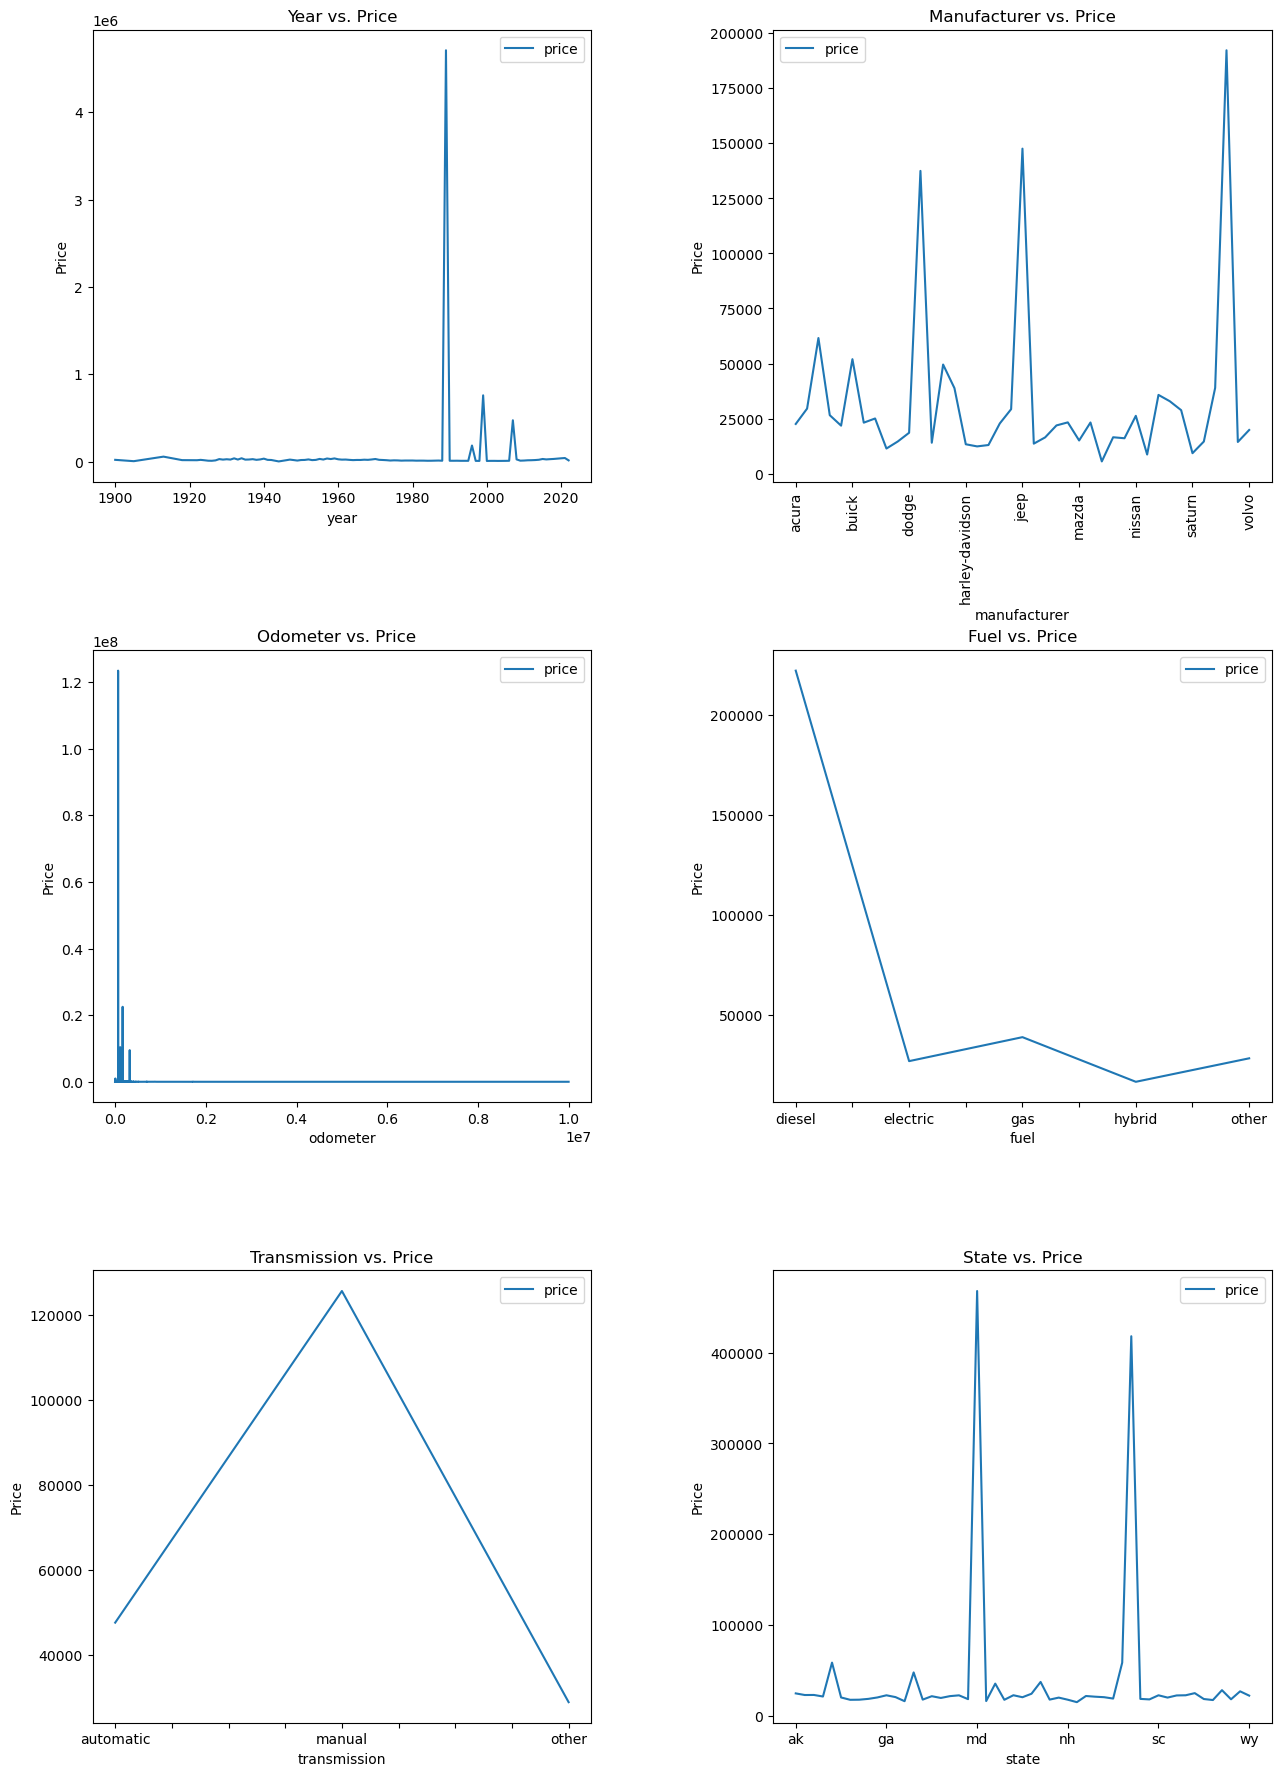

In [144]:
fig, axes = plt.subplots(3, 2, figsize=(15, 20))
fig.tight_layout(pad=10, w_pad=10, h_pad=10)
ax1, ax2, ax3, ax4, ax5 , ax6= axes.flatten()


car_prepdf.groupby('year')[['price']].mean().plot(ax=ax1)
ax1.set_title('Year vs. Price')
ax1.set_ylabel('Price')

car_prepdf.groupby('manufacturer')[['price']].mean().plot(ax=ax2)
ax2.set_title('Manufacturer vs. Price')
ax2.set_ylabel('Price')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

car_prepdf.groupby('odometer')[['price']].mean().plot(ax=ax3)
ax3.set_title('Odometer vs. Price  ')
ax3.set_ylabel('Price')

car_prepdf.groupby('fuel')[['price']].mean().plot(ax=ax4)
ax4.set_title('Fuel vs. Price')
ax4.set_ylabel('Price')

car_prepdf.groupby('transmission')[['price']].mean().plot(ax=ax5)
ax5.set_title('Transmission vs. Price')
ax5.set_ylabel('Price')

car_prepdf.groupby('state')[['price']].mean().plot(ax=ax6)
ax6.set_title('State vs. Price')
ax6.set_ylabel('Price')